In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e9b5b2461d1dfc7b1451ac0688ee4fd776165620073c6aeb5a8f8361f1828c4d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
import pandas as pd
import os

# Load and process Flickr8k captions.txt
captions_file = "/kaggle/input/flickr8k/captions.txt"
df = pd.read_csv(captions_file, delimiter="|", names=["image_name", "caption"], skiprows=1)

# Strip spaces and remove unnecessary characters
df["image_name"] = df["image_name"].str.strip()
df["caption"] = df["caption"].astype(str).str.strip()

# Save as CSV
csv_path = "/kaggle/working/captions.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)  # Create directory if needed

df.to_csv(csv_path, index=False)
print("Captions saved as CSV:", csv_path)


Captions saved as CSV: /kaggle/working/captions.csv


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]


Generated Caption:
 a photo of a black and white dog standing in a pool of water 

Generated Hashtags:
 #photo #black #white #standing #pool #water 

Reference Captions:
 A black and white dog drinking water from a water spray .
A black and white dog is being soaked with a jet of water in a blue paddling pool .
A dog sticking its face into the shower from a garden hose .
A small white dog gets sprayed by water
A white and black dog is jumping into a pool . 

BLEU Score: 37.24 %
METEOR Score: 42.24 %
ROUGE-L Score: 41.25 %



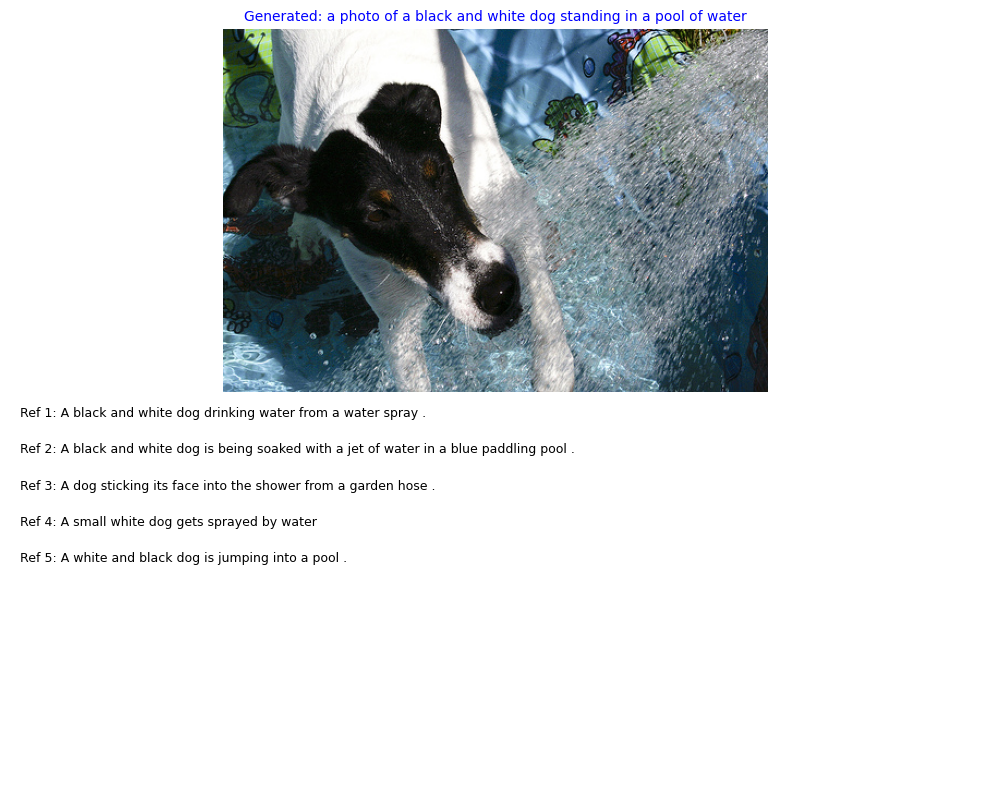

In [ ]:
import torch
import torchvision.transforms as transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
from PIL import Image
import re
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def get_first_synonym(word):
    synsets = wordnet.synsets(word)
    if synsets:
        lemmas = synsets[0].lemma_names()
        return lemmas[0].lower().replace("_", " ") if lemmas else word
    return word

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip-image-captioning-large"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

captions_df = pd.read_csv("/kaggle/working/captions.csv", header=None, names=["image_name_caption", "nan"])
captions_df[['image_name', 'caption']] = captions_df['image_name_caption'].str.split(',', n=1, expand=True)
captions_df["image_name"] = captions_df["image_name"].str.strip()
captions_df["caption"] = captions_df["caption"].str.strip()
captions_df = captions_df.drop(columns=["image_name_caption", "nan"])
captions_df = captions_df[captions_df['image_name'].str.strip() != '']
captions_df = captions_df[captions_df['caption'].str.strip() != '']
captions_df = captions_df.dropna(subset=["image_name", "caption"])
captions_df = captions_df[captions_df["caption"].str.len() > 10]

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower()).strip()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    synonym_mapped = [get_first_synonym(word) for word in lemmatized_tokens]
    return ' '.join(synonym_mapped)

def get_reference_captions(image_name):
    refs = captions_df[captions_df["image_name"] == image_name]["caption"].tolist()
    return refs[:5] if len(refs) >= 5 else refs + [""] * (5 - len(refs))

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def generate_caption(image_path):
    image = preprocess_image(image_path)
    inputs = processor(images=image, text="a photo of", return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=50,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    caption = processor.batch_decode(output, skip_special_tokens=True)[0]
    return caption

def generate_hashtags(caption):
    words = re.findall(r'\b\w{4,}\b', caption)
    hashtags = ["#" + word.lower() for word in words]
    return " ".join(hashtags)

def calculate_bleu_score(generated_caption, reference_captions):
    if not reference_captions:
        return 0.0
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_captions]
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu_score * 100

def calculate_meteor_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    scores = [meteor_score([nltk.word_tokenize(ref)], generated_tokens) for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def calculate_rouge_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, generated_caption)['rougeL'].fmeasure for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def display_reference_vs_generated(image_path, generated, references):
    image = preprocess_image(image_path)
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Generated: " + generated, fontsize=10, color='blue', wrap=True)

    plt.subplot(2, 1, 2)
    plt.axis("off")
    y_offset = 1.0
    for i, ref in enumerate(references):
        plt.text(0.01, y_offset - i * 0.1, f"Ref {i+1}: {ref}", fontsize=9, wrap=True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    #image_path = "/kaggle/input/flickr8k/Images/1055623002_8195a43714.jpg"
    #image_name = "1055623002_8195a43714.jpg"
    image_path = "/kaggle/input/flickr8k/Images/1096097967_ac305887b4.jpg"
    image_name = "1096097967_ac305887b4.jpg"
    caption = generate_caption(image_path)
    hashtags = generate_hashtags(caption)
    reference_captions = get_reference_captions(image_name)

    bleu = calculate_bleu_score(caption, reference_captions)
    meteor = calculate_meteor_score(caption, reference_captions)
    rouge = calculate_rouge_score(caption, reference_captions)

    print("\nGenerated Caption:\n", caption, "\n")
    print("Generated Hashtags:\n", hashtags, "\n")
    print("Reference Captions:\n", "\n".join(reference_captions), "\n")
    print("BLEU Score:", round(bleu, 2), "%")
    print("METEOR Score:", round(meteor, 2), "%")
    print("ROUGE-L Score:", round(rouge, 2), "%\n")

    display_reference_vs_generated(image_path, caption, reference_captions)


In [ ]:
import torch
import torchvision.transforms as transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
from PIL import Image
import re
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import os

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def get_first_synonym(word):
    synsets = wordnet.synsets(word)
    if synsets:
        lemmas = synsets[0].lemma_names()
        return lemmas[0].lower().replace("_", " ") if lemmas else word
    return word

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip-image-captioning-large"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

captions_df = pd.read_csv("/kaggle/working/captions.csv", header=None, names=["image_name_caption", "nan"])
captions_df[['image_name', 'caption']] = captions_df['image_name_caption'].str.split(',', n=1, expand=True)
captions_df["image_name"] = captions_df["image_name"].str.strip()
captions_df["caption"] = captions_df["caption"].str.strip()
captions_df = captions_df.drop(columns=["image_name_caption", "nan"])
captions_df = captions_df[captions_df['image_name'].str.strip() != '']
captions_df = captions_df[captions_df['caption'].str.strip() != '']
captions_df = captions_df.dropna(subset=["image_name", "caption"])
captions_df = captions_df[captions_df["caption"].str.len() > 10]

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower()).strip()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    synonym_mapped = [get_first_synonym(word) for word in lemmatized_tokens]
    return ' '.join(synonym_mapped)

def get_reference_captions(image_name):
    refs = captions_df[captions_df["image_name"] == image_name]["caption"].tolist()
    return refs[:5] if len(refs) >= 5 else refs + [""] * (5 - len(refs))

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def generate_caption(image_path):
    image = preprocess_image(image_path)
    inputs = processor(images=image, text="a photo of", return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=50,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    caption = processor.batch_decode(output, skip_special_tokens=True)[0]
    return caption

def generate_hashtags(caption):
    words = re.findall(r'\b\w{4,}\b', caption)
    hashtags = ["#" + word.lower() for word in words]
    return " ".join(hashtags)

def calculate_bleu_score(generated_caption, reference_captions):
    if not reference_captions:
        return 0.0
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_captions]
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu_score * 100

def calculate_meteor_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    scores = [meteor_score([nltk.word_tokenize(ref)], generated_tokens) for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def calculate_rouge_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, generated_caption)['rougeL'].fmeasure for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def evaluate_batch(image_dir, sample_size=20):
    bleu_scores = []
    meteor_scores = []
    rouge_scores = []

    sampled_df = captions_df.sample(n=sample_size, random_state=42)

    for idx, row in sampled_df.iterrows():
        image_name = row['image_name']
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            print(f"[!] Skipping missing image: {image_name}")
            continue

        caption = generate_caption(image_path)
        references = get_reference_captions(image_name)

        bleu = calculate_bleu_score(caption, references)
        meteor = calculate_meteor_score(caption, references)
        rouge = calculate_rouge_score(caption, references)

        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        rouge_scores.append(rouge)

        print(f"\n🖼️ Image: {image_name}")
        print(f"Generated: {caption}")
        print(f"BLEU: {round(bleu, 2)}%, METEOR: {round(meteor, 2)}%, ROUGE-L: {round(rouge, 2)}%\n")

    print("\n===== 🔚 Average Scores Across Batch =====")
    print(f"Average BLEU-4 Score: {round(sum(bleu_scores) / len(bleu_scores), 2)}%")
    print(f"Average METEOR Score: {round(sum(meteor_scores) / len(meteor_scores), 2)}%")
    print(f"Average ROUGE-L Score: {round(sum(rouge_scores) / len(rouge_scores), 2)}%")

if __name__ == "__main__":
    image_dir = "/kaggle/input/flickr8k/Images"  # Update if using a different path
    evaluate_batch(image_dir, sample_size=20)  # Change sample_size as needed



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]


🖼️ Image: 3119887967_271a097464.jpg
Generated: a photo of two men standing next to each other in a room
BLEU: 8.38%, METEOR: 18.75%, ROUGE-L: 17.76%


🖼️ Image: 3440724965_03d6ca5399.jpg
Generated: a photo of a man sitting in a chair with his hands on his head
BLEU: 33.16%, METEOR: 32.74%, ROUGE-L: 33.5%


🖼️ Image: 2888386138_578d21033a.jpg
Generated: a photo of a little boy standing on the stairs in a house
BLEU: 30.13%, METEOR: 47.79%, ROUGE-L: 45.77%


🖼️ Image: 3084001782_41a848df4e.jpg
Generated: a photo of a group of people sitting around a table with drinks
BLEU: 4.16%, METEOR: 12.67%, ROUGE-L: 21.85%


🖼️ Image: 2934628301_41ea2e6cf9.jpg
Generated: a photo of a dog splashes in the water at the beach
BLEU: 34.48%, METEOR: 32.11%, ROUGE-L: 40.88%


🖼️ Image: 1141718391_24164bf1b1.jpg
Generated: a photo of a man and a woman standing on a rope bridge
BLEU: 40.9%, METEOR: 45.89%, ROUGE-L: 49.79%


🖼️ Image: 3227499174_07feb26337.jpg
Generated: a photo of a bride and groom standing

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
from PIL import Image, ImageEnhance, ImageFilter
import re
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import gradio as gr
import io
import base64
import tempfile

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def get_first_synonym(word):
    synsets = wordnet.synsets(word)
    if synsets:
        lemmas = synsets[0].lemma_names()
        return lemmas[0].lower().replace("_", " ") if lemmas else word
    return word

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip-image-captioning-large"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

captions_df = pd.read_csv("/kaggle/working/captions.csv", header=None, names=["image_name_caption", "nan"])
captions_df = captions_df[captions_df['image_name_caption'].str.contains(',', na=False)]
captions_df[['image_name', 'caption']] = captions_df['image_name_caption'].str.split(',', n=1, expand=True)
captions_df["image_name"] = captions_df["image_name"].str.strip()
captions_df["caption"] = captions_df["caption"].str.strip()
captions_df = captions_df.drop(columns=["image_name_caption", "nan"])
captions_df = captions_df[captions_df['image_name'].str.strip() != '']
captions_df = captions_df[captions_df['caption'].str.strip() != '']
captions_df = captions_df.dropna(subset=["image_name", "caption"])
captions_df = captions_df[captions_df["caption"].str.len() > 10]

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower()).strip()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    synonym_mapped = [get_first_synonym(word) for word in lemmatized_tokens]
    return ' '.join(synonym_mapped)

def get_reference_captions(image_name):
    refs = captions_df[captions_df["image_name"] == image_name]["caption"].tolist()
    return refs[:5] if len(refs) >= 5 else refs + [""] * (5 - len(refs))

def enhance_image(image, contrast=1.5, sharpness=2.0, brightness=1.0, color=1.0, denoise=False, edge=False, blur_strength=0, crop_box=None):
    if crop_box:
        image = image.crop(crop_box)
    image = ImageEnhance.Contrast(image).enhance(contrast)
    image = ImageEnhance.Sharpness(image).enhance(sharpness)
    image = ImageEnhance.Brightness(image).enhance(brightness)
    image = ImageEnhance.Color(image).enhance(color)
    if denoise:
        image = image.filter(ImageFilter.MedianFilter(size=3))
    if edge:
        image = image.filter(ImageFilter.EDGE_ENHANCE)
    if blur_strength > 0:
        image = image.filter(ImageFilter.GaussianBlur(radius=blur_strength))
    return image

def generate_caption(image):
    inputs = processor(images=image, text="a photo of", return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=50,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    caption = processor.batch_decode(output, skip_special_tokens=True)[0]
    return caption

def generate_hashtags(caption):
    words = re.findall(r'\b\w{4,}\b', caption)
    hashtags = ["#" + word.lower() for word in words]
    return " ".join(hashtags)

def run_captioning(image, contrast, sharpness, brightness, color, denoise, edge, blur_strength, crop_box):
    if isinstance(image, str):
        image_name = image.split("/")[-1]
        image = Image.open(image).convert("RGB")
    else:
        image_name = "uploaded_image.jpg"
    enhanced_image = enhance_image(image, contrast, sharpness, brightness, color, denoise, edge, blur_strength, crop_box)
    caption = generate_caption(enhanced_image)
    hashtags = generate_hashtags(caption)
    full_caption = f"{caption}\n\nHashtags: {hashtags}"
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as f:
        enhanced_image.save(f.name)
        download_path = f.name
    return full_caption, download_path

def inference_ui(image, contrast, sharpness, brightness, color, denoise, edge, blur_strength, crop_box):
    caption, file_path = run_captioning(image, contrast, sharpness, brightness, color, denoise, edge, blur_strength, crop_box)
    return caption, file_path

def live_preview(image, contrast, sharpness, brightness, color, denoise, edge, blur_strength, crop_box):
    if image is None:
        return None
    image = image.convert("RGB")
    enhanced = enhance_image(image, contrast, sharpness, brightness, color, denoise, edge, blur_strength, crop_box)
    return enhanced

with gr.Blocks() as demo:
    with gr.Row():
        image_input = gr.Image(type="pil", label="Upload Image")
        contrast_slider = gr.Slider(0.5, 3.0, value=1.5, label="Contrast")
        sharpness_slider = gr.Slider(0.5, 3.0, value=2.0, label="Sharpness")
        brightness_slider = gr.Slider(0.5, 2.0, value=1.0, label="Brightness")
        color_slider = gr.Slider(0.5, 2.0, value=1.0, label="Color/Saturation")
    with gr.Row():
        denoise_checkbox = gr.Checkbox(label="Denoise", value=False)
        edge_checkbox = gr.Checkbox(label="Enhance Edges", value=False)
        blur_slider = gr.Slider(0, 5, value=0, step=1, label="Blur Strength")
    with gr.Row():
        crop_coords = gr.Textbox(label="Crop Box (left, upper, right, lower)", placeholder="e.g., 100,100,400,400")
    crop_box = gr.State(value=None)
    enhanced_preview = gr.Image(label="Enhanced Preview")
    caption_output = gr.Textbox(lines=10, label="Caption")
    download_btn = gr.File(label="Download Enhanced Image")

    def parse_crop_box(crop_text):
        try:
            parts = [int(x.strip()) for x in crop_text.split(",")]
            if len(parts) == 4:
                return tuple(parts)
        except:
            pass
        return None

    for ctrl in [image_input, contrast_slider, sharpness_slider, brightness_slider, color_slider, denoise_checkbox, edge_checkbox, blur_slider, crop_coords]:
        ctrl.change(fn=lambda img, c, s, b, col, d, e, bl, ct: live_preview(img, c, s, b, col, d, e, bl, parse_crop_box(ct)),
                    inputs=[image_input, contrast_slider, sharpness_slider, brightness_slider, color_slider, denoise_checkbox, edge_checkbox, blur_slider, crop_coords],
                    outputs=enhanced_preview)

    submit_btn = gr.Button("Generate Caption")
    submit_btn.click(fn=lambda img, c, s, b, col, d, e, bl, ct: inference_ui(img, c, s, b, col, d, e, bl, parse_crop_box(ct)),
                     inputs=[image_input, contrast_slider, sharpness_slider, brightness_slider, color_slider, denoise_checkbox, edge_checkbox, blur_slider, crop_coords],
                     outputs=[caption_output, download_btn])

    demo.launch()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://46d64940dc5a19e6a1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## --- End of Flickr8k Code, Start of Flickr30k Code ---

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c43a7ec3d93ae3f4ba338b5e430db6c91c0da89304ed8ff7da2a1d826586f01d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr30k")

print("Path to dataset files:", path)

100%|██████████| 8.16G/8.16G [01:43<00:00, 84.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1


In [ ]:
import pandas as pd
import os

# Load and process Flickr8k captions.txt
captions_file = "/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.txt"
df = pd.read_csv(captions_file, delimiter="|", names=["image_name", "caption"], skiprows=1)

# Strip spaces and remove unnecessary characters
df["image_name"] = df["image_name"].str.strip()
df["caption"] = df["caption"].astype(str).str.strip()

# Save as CSV
csv_path = "/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)  # Create directory if needed

df.to_csv(csv_path, index=False)
print("Captions saved as CSV:", csv_path)


Captions saved as CSV: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.csv


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Generated Caption:
 a photo of a group of people walking down a street holding rainbow flags 

Generated Hashtags:
 #photo #group #people #walking #down #street #holding #rainbow #flags 

Reference Captions:
 " During a gay pride parade in an Asian city , some people hold up rainbow flags to show support ."
A group of youths march down the street waving flags showing the color spectrum .
Oriental people with rainbow flags walking down a city street .
A group of people walk down the street waving rainbow flags .
People are outside waving flags . 

BLEU Score: 41.46 %
METEOR Score: 39.8 %
ROUGE-L Score: 39.93 %



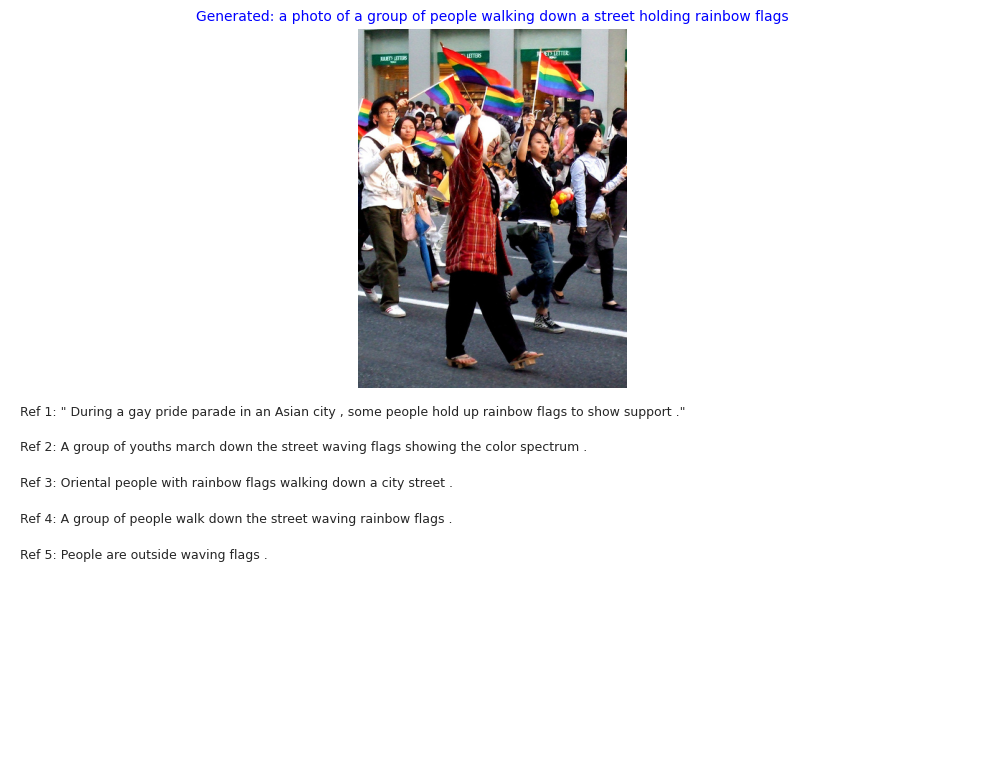

In [ ]:
import torch
import torchvision.transforms as transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
from PIL import Image
import re
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def get_first_synonym(word):
    synsets = wordnet.synsets(word)
    if synsets:
        lemmas = synsets[0].lemma_names()
        return lemmas[0].lower().replace("_", " ") if lemmas else word
    return word

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip-image-captioning-large"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

captions_df = pd.read_csv("/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.csv", header=None, names=["image_name_caption", "nan"])
captions_df[['image_name', 'caption']] = captions_df['image_name_caption'].str.split(',', n=1, expand=True)
captions_df["image_name"] = captions_df["image_name"].str.strip()
captions_df["caption"] = captions_df["caption"].str.strip()
captions_df = captions_df.drop(columns=["image_name_caption", "nan"])
captions_df = captions_df[captions_df['image_name'].str.strip() != '']
captions_df = captions_df[captions_df['caption'].str.strip() != '']
captions_df = captions_df.dropna(subset=["image_name", "caption"])
captions_df = captions_df[captions_df["caption"].str.len() > 10]

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower()).strip()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    synonym_mapped = [get_first_synonym(word) for word in lemmatized_tokens]
    return ' '.join(synonym_mapped)

def get_reference_captions(image_name):
    refs = captions_df[captions_df["image_name"] == image_name]["caption"].tolist()
    return refs[:5] if len(refs) >= 5 else refs + [""] * (5 - len(refs))

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def generate_caption(image_path):
    image = preprocess_image(image_path)
    inputs = processor(images=image, text="a photo of", return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=50,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    caption = processor.batch_decode(output, skip_special_tokens=True)[0]
    return caption

def generate_hashtags(caption):
    words = re.findall(r'\b\w{4,}\b', caption)
    hashtags = ["#" + word.lower() for word in words]
    return " ".join(hashtags)

def calculate_bleu_score(generated_caption, reference_captions):
    if not reference_captions:
        return 0.0
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_captions]
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu_score * 100

def calculate_meteor_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    scores = [meteor_score([nltk.word_tokenize(ref)], generated_tokens) for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def calculate_rouge_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, generated_caption)['rougeL'].fmeasure for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def display_reference_vs_generated(image_path, generated, references):
    image = preprocess_image(image_path)
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Generated: " + generated, fontsize=10, color='blue', wrap=True)

    plt.subplot(2, 1, 2)
    plt.axis("off")
    y_offset = 1.0
    for i, ref in enumerate(references):
        plt.text(0.01, y_offset - i * 0.1, f"Ref {i+1}: {ref}", fontsize=9, wrap=True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    image_path = "/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/Images/1029802110.jpg"
    image_name = "1029802110.jpg"
    caption = generate_caption(image_path)
    hashtags = generate_hashtags(caption)
    reference_captions = get_reference_captions(image_name)

    bleu = calculate_bleu_score(caption, reference_captions)
    meteor = calculate_meteor_score(caption, reference_captions)
    rouge = calculate_rouge_score(caption, reference_captions)

    print("\nGenerated Caption:\n", caption, "\n")
    print("Generated Hashtags:\n", hashtags, "\n")
    print("Reference Captions:\n", "\n".join(reference_captions), "\n")
    print("BLEU Score:", round(bleu, 2), "%")
    print("METEOR Score:", round(meteor, 2), "%")
    print("ROUGE-L Score:", round(rouge, 2), "%\n")

    display_reference_vs_generated(image_path, caption, reference_captions)


In [ ]:
import torch
import torchvision.transforms as transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
from PIL import Image
import re
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import os

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def get_first_synonym(word):
    synsets = wordnet.synsets(word)
    if synsets:
        lemmas = synsets[0].lemma_names()
        return lemmas[0].lower().replace("_", " ") if lemmas else word
    return word

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip-image-captioning-large"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

captions_df = pd.read_csv("/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.csv", header=None, names=["image_name_caption", "nan"])
captions_df[['image_name', 'caption']] = captions_df['image_name_caption'].str.split(',', n=1, expand=True)
captions_df["image_name"] = captions_df["image_name"].str.strip()
captions_df["caption"] = captions_df["caption"].str.strip()
captions_df = captions_df.drop(columns=["image_name_caption", "nan"])
captions_df = captions_df[captions_df['image_name'].str.strip() != '']
captions_df = captions_df[captions_df['caption'].str.strip() != '']
captions_df = captions_df.dropna(subset=["image_name", "caption"])
captions_df = captions_df[captions_df["caption"].str.len() > 10]

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower()).strip()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    synonym_mapped = [get_first_synonym(word) for word in lemmatized_tokens]
    return ' '.join(synonym_mapped)

def get_reference_captions(image_name):
    refs = captions_df[captions_df["image_name"] == image_name]["caption"].tolist()
    return refs[:5] if len(refs) >= 5 else refs + [""] * (5 - len(refs))

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def generate_caption(image_path):
    image = preprocess_image(image_path)
    inputs = processor(images=image, text="a photo of", return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=50,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    caption = processor.batch_decode(output, skip_special_tokens=True)[0]
    return caption

def generate_hashtags(caption):
    words = re.findall(r'\b\w{4,}\b', caption)
    hashtags = ["#" + word.lower() for word in words]
    return " ".join(hashtags)

def calculate_bleu_score(generated_caption, reference_captions):
    if not reference_captions:
        return 0.0
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_captions]
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu_score * 100

def calculate_meteor_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption)
    scores = [meteor_score([nltk.word_tokenize(ref)], generated_tokens) for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def calculate_rouge_score(generated_caption, reference_captions):
    generated_caption = normalize_text(generated_caption)
    reference_captions = [normalize_text(ref) for ref in reference_captions]
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, generated_caption)['rougeL'].fmeasure for ref in reference_captions]
    return sum(scores) / len(scores) * 100 if scores else 0.0

def evaluate_batch(image_dir, sample_size=20):
    bleu_scores = []
    meteor_scores = []
    rouge_scores = []

    sampled_df = captions_df.sample(n=sample_size, random_state=42)

    for idx, row in sampled_df.iterrows():
        image_name = row['image_name']
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            print(f"[!] Skipping missing image: {image_name}")
            continue

        caption = generate_caption(image_path)
        references = get_reference_captions(image_name)

        bleu = calculate_bleu_score(caption, references)
        meteor = calculate_meteor_score(caption, references)
        rouge = calculate_rouge_score(caption, references)

        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        rouge_scores.append(rouge)

        print(f"\n🖼️ Image: {image_name}")
        print(f"Generated: {caption}")
        print(f"BLEU: {round(bleu, 2)}%, METEOR: {round(meteor, 2)}%, ROUGE-L: {round(rouge, 2)}%\n")

    print("\n===== 🔚 Average Scores Across Batch =====")
    print(f"Average BLEU-4 Score: {round(sum(bleu_scores) / len(bleu_scores), 2)}%")
    print(f"Average METEOR Score: {round(sum(meteor_scores) / len(meteor_scores), 2)}%")
    print(f"Average ROUGE-L Score: {round(sum(rouge_scores) / len(rouge_scores), 2)}%")

if __name__ == "__main__":
    # Update `image_dir` to the correct path where images are downloaded
    image_dir = "/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/Images"
    evaluate_batch(image_dir, sample_size=20)  # Change sample_size as needed


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



🖼️ Image: 280435773.jpg
Generated: a photo of a man standing at a podium with a laptop
BLEU: 13.5%, METEOR: 27.8%, ROUGE-L: 32.47%


🖼️ Image: 54817316.jpg
Generated: a photo of a little girl laying on a couch covered in a blanket
BLEU: 14.28%, METEOR: 25.35%, ROUGE-L: 37.26%


🖼️ Image: 205635075.jpg
Generated: a photo of a group of chefs standing on a balcony
BLEU: 34.53%, METEOR: 33.47%, ROUGE-L: 38.61%


🖼️ Image: 3456251289.jpg
Generated: a photo of a person on a dirt bike in the air
BLEU: 13.95%, METEOR: 28.72%, ROUGE-L: 27.6%


🖼️ Image: 2183967273.jpg
Generated: a photo of a dog playing with a stuffed animal on the floor
BLEU: 13.07%, METEOR: 36.04%, ROUGE-L: 34.09%


🖼️ Image: 3333860706.jpg
Generated: a photo of a group of people sitting on a beach next to the ocean
BLEU: 8.09%, METEOR: 26.33%, ROUGE-L: 31.28%


🖼️ Image: 4920306992.jpg
Generated: a photo of a train station with two trains and a clock
BLEU: 39.18%, METEOR: 22.36%, ROUGE-L: 27.45%


🖼️ Image: 4094966503.jpg
G

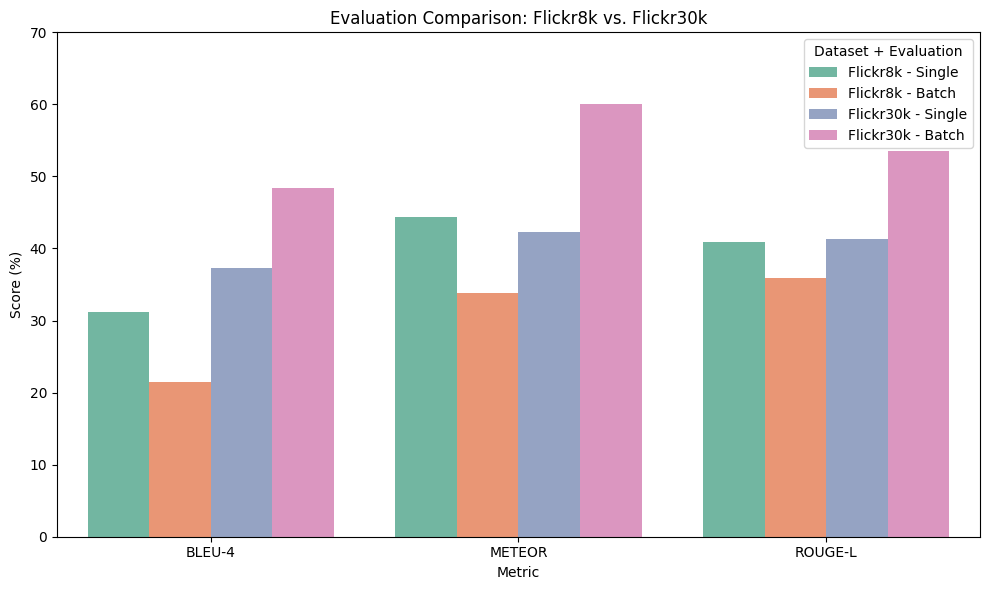

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create the data
data = {
    'Metric': ['BLEU-4', 'METEOR', 'ROUGE-L'] * 4,
    'Score': [31.17, 44.32, 40.97,   # Flickr8k - Single
              21.47, 33.86, 35.91,   # Flickr8k - Batch
              37.24, 42.24, 41.25,   # Flickr30k - Single
              48.44, 60.09, 53.48],  # Flickr30k - Batch
    'Dataset + Eval': ['Flickr8k - Single'] * 3 +
                      ['Flickr8k - Batch'] * 3 +
                      ['Flickr30k - Single'] * 3 +
                      ['Flickr30k - Batch'] * 3
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Dataset + Eval', data=df, palette='Set2')

plt.title('Evaluation Comparison: Flickr8k vs. Flickr30k')
plt.ylabel('Score (%)')
plt.xlabel('Metric')
plt.ylim(0, 70)
plt.legend(title='Dataset + Evaluation')
plt.tight_layout()
plt.show()


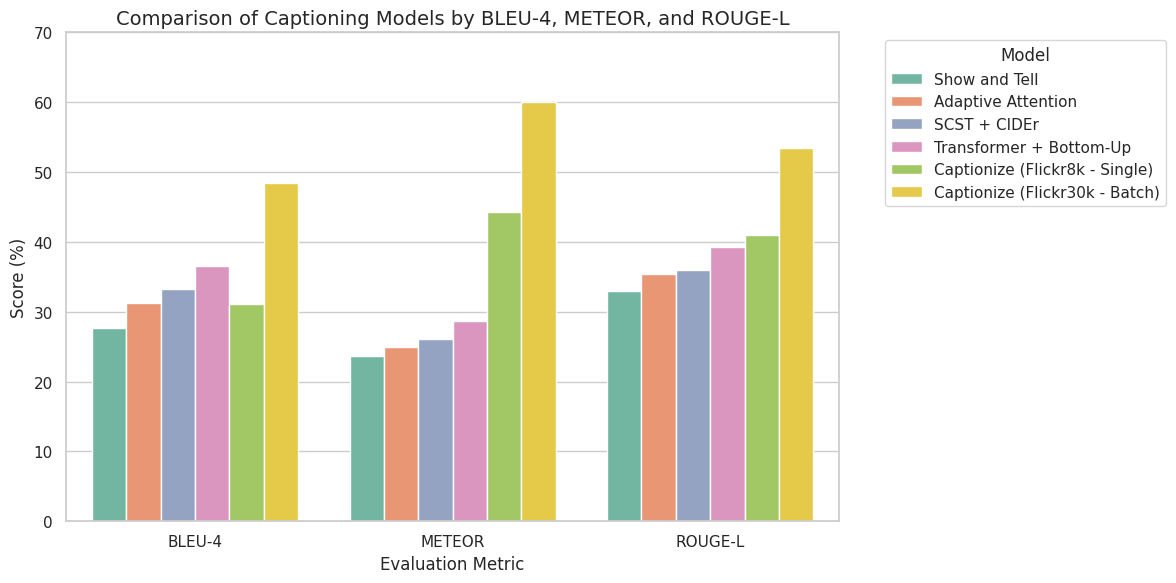

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data setup from your table
data = {
    'Metric': ['BLEU-4', 'METEOR', 'ROUGE-L'] * 6,
    'Score': [
        27.7, 23.7, 32.9,     # Show and Tell
        31.2, 25.0, 35.4,     # Adaptive Attention
        33.2, 26.1, 36.0,     # SCST + CIDEr
        36.5, 28.6, 39.2,     # Transformer + Bottom-Up
        31.17, 44.32, 40.97,  # Captionize (Flickr8k - Single)
        48.44, 60.09, 53.48   # Captionize (Flickr30k - Batch)
    ],
    'Model': ['Show and Tell'] * 3 +
             ['Adaptive Attention'] * 3 +
             ['SCST + CIDEr'] * 3 +
             ['Transformer + Bottom-Up'] * 3 +
             ['Captionize (Flickr8k - Single)'] * 3 +
             ['Captionize (Flickr30k - Batch)'] * 3
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(data=df, x='Metric', y='Score', hue='Model', palette='Set2')

# Customize
plt.title('Comparison of Captioning Models by BLEU-4, METEOR, and ROUGE-L', fontsize=14)
plt.ylabel('Score (%)')
plt.xlabel('Evaluation Metric')
plt.ylim(0, 70)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()
